##### Copyright 2018 The TensorFlow Authors.

# **Proj1B - Logistic Regression:** Understanding the ADNI Data Using Regression  

> ### **(34 points) || Due by 9/30 11:59pm**





<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Instructions

Please make a copy and rename it with your name (ex: Proj1B_Ilmi_Yoon). All grading points should be explored in the notebook but some can be done in a separate pdf file. 

*Graded questions will be listed with "Q:" followed by the corresponding points.* 

You will be submitting a **pdf** file containing **the url of your own proj1B.**


---



## Table of Contents

Introduction *(Points: 34)*
1. Load in the Data
2. Clean the Data
3. Inspect the Data
4. Select a Few Features to Work On and Split Features from Labels
5. Normalization

  5.1 The Normalization Layer

6. Logistic Regression

  6.1 One Variable *(Points: 39)*
 
  6.2 Multiple Variable: Features *(Points: 5)*


Conclusion

---



## Introduction

In a **regression** problem, the aim is to *predict the output of a continuous value*, like a price or a probability.

Contrast this with a **classification** problem, where the aim is to *select a class from a list of classes* (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This example uses the `tf.keras API`, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
# !pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


In [4]:
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:", tf.__version__)
print()
print(device_lib.list_local_devices())

Num GPUs Available:  1
Tensorflow version: 2.5.0

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6468052121985615812
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9392422912
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8727735291737301137
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0b:00.0, compute capability: 7.5"
]


### 1. Load in the Data
First download and import the dataset using pandas:

In [5]:
url = "https://raw.githubusercontent.com/pleunipennings/CSC508Data/main/PatData.csv"
data = pd.read_csv(url)

In [6]:
dataset = data.copy()
dataset.tail()

,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
1732,941_S_4377,69.3,Female,12,Not Hisp/Latino,White,Widowed,1.0,MCI,19850.0,6276.500000,854605.0,3098.750000,14773.000000,16232.75,1.307478e+06
1733,941_S_4420,81.4,Male,18,Not Hisp/Latino,White,Married,0.0,MCI,45450.5,7542.250000,1125837.5,4501.750000,16491.250000,17802.75,1.658722e+06
1734,941_S_4764,82.7,Female,20,Not Hisp/Latino,White,Never married,0.0,MCI,63228.5,6092.500000,915772.5,3933.666667,17667.333333,17832.00,1.483815e+06
1735,941_S_5124,76.7,Female,20,Not Hisp/Latino,White,Married,0.0,NL,NaN,4691.666667,NaN,NaN,NaN,NaN,1.489683e+06
1736,941_S_5193,72.5,Female,16,Not Hisp/Latino,White,Married,0.0,NL,22958.5,7009.500000,1026105.0,4007.500000,15812.500000,17461.00,1.465065e+06


In [7]:
dataset['DX'].value_counts()

MCI                586
Dementia           577
NL                 423
MCI to Dementia    108
NL to MCI           29
NL to Dementia       3
MCI to NL            3
Dementia to MCI      1
Name: DX, dtype: int64

So, I would like to take out everything in the dataset **EXCEPT** the following levels: NL and Dementia (for binary classification for now). 

*NL = cognitively normal , MCI = mild cognitive impairement.*

In [8]:
"""
Get rows where Column DX vlaue != to "NL" or Column DX vlaue != "Demntia".
This means you will get all rows like "MCI to Demntia" and "MCI"
"""
index_to_drop = dataset[(dataset['DX'] != "NL") &
                        (dataset['DX'] != "Dementia")].index

# drop these given row indices from data
dataset = dataset.drop(index_to_drop)

In [9]:
# Dataset now has data for DX == "Demntia" and DX == "NL"
dataset['DX'].value_counts()

Dementia    577
NL          423
Name: DX, dtype: int64

### 2. Clean the Data

The dataset contains a few unknown values. To see how many unknown values, use the following code:

In [10]:
# This is to show all NA values in the Dataset
dataset.isna().sum()

PTID            0
AGE             0
PTGENDER        0
PTEDUCAT        0
PTETHCAT        0
PTRACCAT        0
PTMARRY         0
APOE4           3
DX              0
Ventricles     16
Hippocampus    39
WholeBrain     10
Entorhinal     70
Fusiform       70
MidTemp        70
ICV             1
dtype: int64

In [11]:
# Drop the NA rows from the dataset
dataset = dataset.dropna()

In [12]:
"""
Map 
    NL to 0
    Dementia to 1
"""
cleanup_DX = {"DX": {"NL": 0, "Dementia": 1}}
dataset = dataset.replace(cleanup_DX)

In [13]:
"""
Split the data into to training and testing datasets

"""
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 3. Inspect the Data

Have a quick look at the joint distribution of a few pairs of columns from the training set. *Can you find the data that show their relationship clearly?*


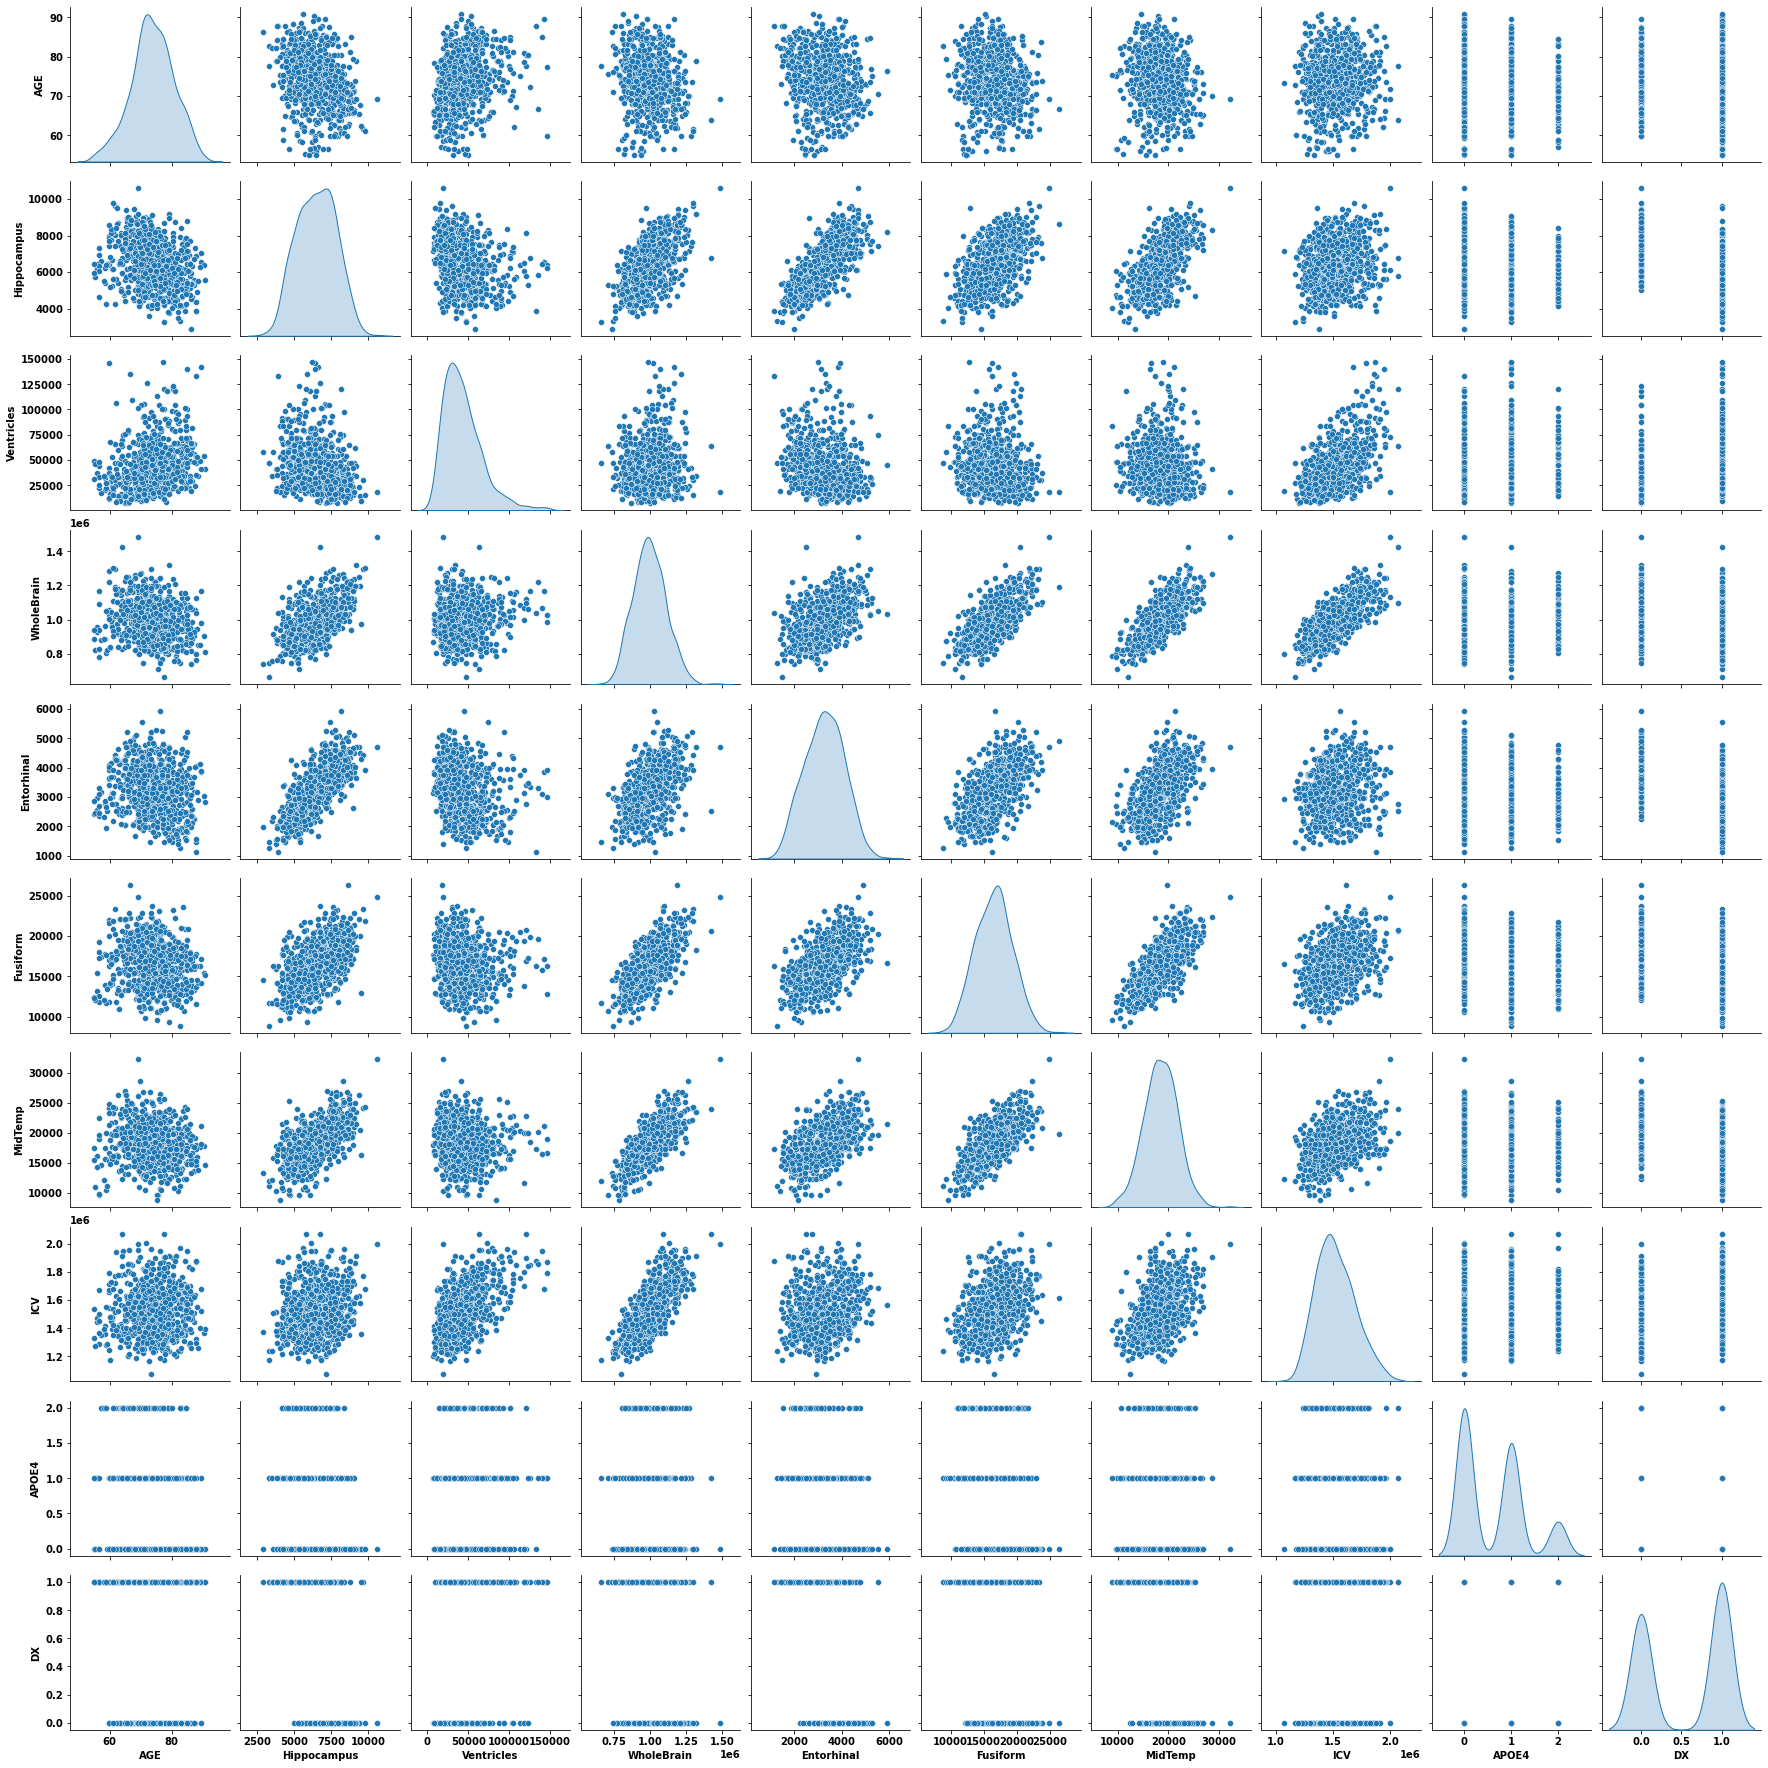

In [14]:
"""
Make a pairplot of the training dataset to find correlations
"""
sns.pairplot(train_dataset[
    [
        "AGE",
        "Hippocampus",
        "Ventricles",
        "WholeBrain",
        "Entorhinal",
        "Fusiform",
        "MidTemp",
        "ICV",
        "APOE4",
        "DX",
    ]
], diag_kind="kde"
)

Also look at the overall statistics, note how each feature covers a very different range:

In [15]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AGE,736.0,7.378791e+01,6.806120,5.510000e+01,6.960000e+01,7.365000e+01,7.840000e+01,9.090000e+01
PTEDUCAT,736.0,1.583696e+01,2.872444,4.000000e+00,1.400000e+01,1.600000e+01,1.800000e+01,2.000000e+01
APOE4,736.0,6.141304e-01,0.684536,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
DX,736.0,5.597826e-01,0.496751,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Ventricles,736.0,4.327182e+04,23584.973866,7.296000e+03,2.625521e+04,3.898842e+04,5.501240e+04,1.466654e+05
Hippocampus,736.0,6.486026e+03,1308.283103,2.894500e+03,5.482333e+03,6.509250e+03,7.480625e+03,1.060200e+04
WholeBrain,736.0,9.979635e+05,113931.813643,6.616225e+05,9.194966e+05,9.944984e+05,1.073055e+06,1.486040e+06
Entorhinal,736.0,3.265773e+03,827.521722,1.143000e+03,2.649300e+03,3.283893e+03,3.861250e+03,5.931000e+03
Fusiform,736.0,1.653037e+04,2772.075954,8.863667e+03,1.452794e+04,1.661283e+04,1.834190e+04,2.629933e+04
MidTemp,736.0,1.847502e+04,3309.121895,8.850333e+03,1.631933e+04,1.846588e+04,2.069904e+04,3.218900e+04


### 4. Select a Few Features to Work On and Split Features from Labels

Separate the target value (the "label") from the features. 

**This label is the value that you will train the model to predict.**

In [16]:
"""
Assign what features and labels to use

Notes:
    features:
    Labels: 

"""

train_features = train_dataset[
    [
        "Hippocampus",
        "WholeBrain",
        "Entorhinal",
        "AGE"
    ]
]

test_features = test_dataset[
    [
        "Hippocampus",
        "WholeBrain",
        "Entorhinal",
        "AGE"
    ]
]


train_labels = train_dataset[
    [
        "DX"
    ]
]

test_labels = test_dataset[
    [
        "DX"
    ]
]

In [17]:
display(train_features)
display(test_features)
display(train_labels)
display(test_labels)

,Hippocampus,WholeBrain,Entorhinal,AGE
506,7484.166667,9.736240e+05,3232.000,72.6
1319,7984.200000,1.058310e+06,3350.000,63.8
492,6156.000000,9.224115e+05,2612.750,79.7
787,6220.000000,8.848287e+05,2806.500,58.4
424,5560.000000,9.872450e+05,2984.000,72.9
...,...,...,...,...
756,8746.750000,1.208455e+06,4530.000,81.1
182,5307.750000,9.433558e+05,2952.250,74.5
785,3833.500000,8.786276e+05,1927.875,78.8
46,4801.500000,8.093530e+05,1827.500,84.5


,Hippocampus,WholeBrain,Entorhinal,AGE
10,4790.000000,9.596880e+05,2044.500000,78.2
12,8072.800000,1.077263e+06,3667.200000,73.6
37,7625.333333,1.094290e+06,4713.000000,68.6
43,6263.000000,8.361541e+05,4056.400000,84.3
52,7408.500000,1.118800e+06,4167.333333,79.3
...,...,...,...,...
1652,5988.000000,1.056200e+06,3304.666667,65.7
1658,4981.666667,8.878585e+05,2095.000000,84.2
1672,5185.000000,9.101820e+05,3676.000000,86.8
1676,6330.000000,1.057645e+06,2705.000000,68.6


,DX
506,1
1319,1
492,1
787,1
424,1
...,...
756,0
182,1
785,1
46,1


,DX
10,1
12,1
37,0
43,0
52,0
...,...
1652,1
1658,1
1672,1
1676,1


## 5. Normalization

In the table of statistics, it's easy to see how different the ranges of each feature are. You can use `.describe().transpose()[['examplefeature']]` to see this.



In [18]:
"""
1. Describe the training features
2. Transpose the df
3. Only show mean and STD
"""
train_features.describe().transpose()[['mean', 'std']]

,mean,std
Hippocampus,6486.025883,1308.283103
WholeBrain,997963.549634,113931.813643
Entorhinal,3265.773175,827.521722
AGE,73.787908,6.806120


### 5.1 The Normalization Layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [19]:
normalizer = preprocessing.Normalization(axis=-1)

Then `.adapt()` it to the data:

In [20]:
normalizer.adapt(np.array(train_features))

In [21]:
display(train_features)

,Hippocampus,WholeBrain,Entorhinal,AGE
506,7484.166667,9.736240e+05,3232.000,72.6
1319,7984.200000,1.058310e+06,3350.000,63.8
492,6156.000000,9.224115e+05,2612.750,79.7
787,6220.000000,8.848287e+05,2806.500,58.4
424,5560.000000,9.872450e+05,2984.000,72.9
...,...,...,...,...
756,8746.750000,1.208455e+06,4530.000,81.1
182,5307.750000,9.433558e+05,2952.250,74.5
785,3833.500000,8.786276e+05,1927.875,78.8
46,4801.500000,8.093530e+05,1827.500,84.5


The following code calculates the mean and variance, and stores them in the layer. 

In [22]:
print("normalizer.mean.numpy()")
display(normalizer.mean.numpy())
print()

print("normalizer")
display(normalizer)

normalizer.mean.numpy()


array([  6486.026, 997963.44 ,   3265.772,     73.788], dtype=float32)


normalizer


When the layer is called, it returns the input data with each feature independently normalized:

In [23]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[  7484.17 973624.     3232.       72.6 ]]

Normalized: [[ 0.76 -0.21 -0.04 -0.17]]


## 6. Logistic regression



### 6.1. One Variable

Start with a single-variable linear regression, to predict `DX` from `hippocampus`.



First, create the hippocampus `Normalization` layer:

In [24]:
one_feature = np.array(train_features['Hippocampus'])


one_feature_normalizer = preprocessing.Normalization(
    input_shape=[1, ], axis=None)

one_feature_normalizer.adapt(one_feature)

Then, build the sequential model:

In [25]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense
from keras.utils import np_utils

one_feature_model = tf.keras.Sequential([
    one_feature_normalizer
])

nb_classes = 2
number_of_features = 1  # X_train.shape[1]
train_labels_in_classes = np_utils.to_categorical(train_labels, nb_classes)

print("train_labels")
display(train_labels)
print()

print("train_labels_in_classes (one hot encoded version of train_labels)")
display(pd.DataFrame(train_labels_in_classes))

train_labels


,DX
506,1
1319,1
492,1
787,1
424,1
...,...
756,0
182,1
785,1
46,1



train_labels_in_classes (one hot encoded version of train_labels)


,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
731,1.0,0.0
732,0.0,1.0
733,0.0,1.0
734,0.0,1.0


Q: **(2 points)** What is the difference between train_labels and train_labels_in_classes?

train_labels is an integer encoding of the NL and Dementia where NL is 0 and Dementia is 1 whereas train_labels_in_classes is a one-hot encoding of NL and Dementia where NL and Dementia are both columns. The value of 1 in the one-hot encoding represents that the current row has the condition of the column, while the value of 0 represents that the current row does not have the condition of the column. For example, if the NL column has 1 then the row has NL (The person has NL) etc... This should not be confused with the integer encoding because if there was another DX result like MCI, MCI will be assigned with the integer 2 whereas in the one-hot encoding it would have its own column.

In [26]:
print("nb_classes", nb_classes)
print("number_of_features", number_of_features)

nb_classes 2
number_of_features 1


In [27]:
one_feature_model.add(
    Dense(
        8,  # Output
        activation='sigmoid',
        #         activation='relu',
        #         activation='sigmoid',
        input_dim=number_of_features
    )
)

# one_feature_model.add(
#     Dense(
#         64,  # Output
#         activation='sigmoid',
#     )
# )

# one_feature_model.add(
#     Dense(
#         64,  # Output
#         activation='sigmoid',
#     )
# )

one_feature_model.add(
    Dense(
        nb_classes,  # Output
        activation='sigmoid',
    )
)
one_feature_model.add(tf.keras.layers.Softmax())


#hippocampus_model.add(Dense(nb_classes,activation = 'softmax',input_dim = number_of_features))

one_feature_model.compile(tf.optimizers.Adam(learning_rate=0.01),
                          loss='categorical_crossentropy',
                          metrics=['accuracy']
                          )

#model.fit(x, y, epoch=10, validation_data=(x_val, y_val))

one_feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0         
Total params: 37
Trainable params: 34
Non-trainable params: 3
_________________________________________________________________


Q: **(5 points)** Explain what is activation? What is sigmoid? What is Softmax? What is categorical_crossentropy? Please answer 300 words or more to answer all the questions.

“activation” in terms of model.compile is a key word argument used to determine what activation function will be used for the model. In terms of what is an activation function, it is a function that given a number determines if that number should be passed into the next neuron. 

Sigmoid in terms of model.compile is the activation function that is used for classification because it bounds a given input’s value between 0 and 1 which is analogous to Yes and No or True and False. What is special about this activation function is what it gives back during backpropagation. In this process it returns a value that essentially says that if you give a value that is far from the actual value of either 0 or 1, it will return a very big value which tells the model to make a big change because that change will get you closer to determining the correct result given a value.

Softmax is also an activation function, but it should only be used on the last layer of your model because its job is to give a probability for each classification and the sum of those values given to each classification is equal to 1. Basically, this function scales the results between 0 and 1 and the sum is equal to 1, these values are useful for cross entropy.

Cross entropy or categorical_crossentropy is a loss function that takes the results of the “softmax” activation function and converts that value into a new value. The derivative of the new value is then used by the optimizer so that the weights and biases in the model can be tuned.

Optimizers are algorithms that tune the model’s weights and biases, which are associated with neurons, by conducting a lot of derivatives in a process called backpropagation. 



Thus, this model will predict `DX` from `hippocampus`.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [28]:
"""
Recall that one_feature is 1 entire column of train_features (Assuming you didn't change any thing, 
The column should be Hippocampus by deafault

"""
display(pd.DataFrame(one_feature).tail())

,0
731,8746.75
732,5307.75
733,3833.50
734,4801.50
735,6938.00


In [29]:
"""

"""
one_feature_model.predict(one_feature[:10])

array([[0.542, 0.458],
       [0.542, 0.458],
       [0.541, 0.459],
       [0.541, 0.459],
       [0.54 , 0.46 ],
       [0.541, 0.459],
       [0.541, 0.459],
       [0.541, 0.459],
       [0.542, 0.458],
       [0.543, 0.457]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` - since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [30]:
%%time


# Train model
history = one_feature_model.fit(
    train_features['Hippocampus'],
    train_labels_in_classes,
    epochs=200,
    batch_size=256,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split=0.2,
    use_multiprocessing=True
)

Wall time: 5.26 s


Visualize the model's training progress using the stats stored in the `history` object.

In [31]:
"""
Print how well the model was trained
"""
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.496748,0.816327,0.467241,0.837838,195
196,0.496682,0.816327,0.467275,0.837838,196
197,0.496660,0.818027,0.467336,0.844595,197
198,0.496654,0.818027,0.467387,0.844595,198
199,0.496635,0.818027,0.467407,0.844595,199


In [32]:
def plot_loss(history):
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [DX]')
    plt.legend()
    plt.grid(True)

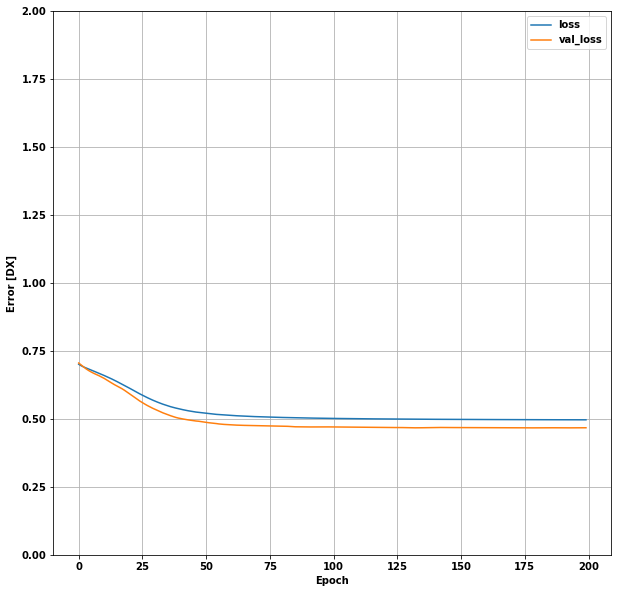

In [33]:
# Print loss graph
plot_loss(history)

Collect the results on the test set and save for later:

In [34]:
test_results = {}

test_lables_in_classes = np_utils.to_categorical(test_labels, nb_classes)

# Test and Record how accurate the model is
test_results['hippocampus_model'] = one_feature_model.evaluate(
    test_features['Hippocampus'],
    test_lables_in_classes, 
    verbose=1
)

6/6 [==============================] - 0s 3ms/step - loss: 0.5184 - accuracy: 0.7826


In [35]:
display(test_features)

pd_df_temp = pd.DataFrame(test_lables_in_classes)
pd_df_temp.columns = ["Nl", "Dementia"]
display(pd_df_temp)
display(pd.concat([test_features, pd_df_temp], axis=1, join='inner'))

display(test_results)

,Hippocampus,WholeBrain,Entorhinal,AGE
10,4790.000000,9.596880e+05,2044.500000,78.2
12,8072.800000,1.077263e+06,3667.200000,73.6
37,7625.333333,1.094290e+06,4713.000000,68.6
43,6263.000000,8.361541e+05,4056.400000,84.3
52,7408.500000,1.118800e+06,4167.333333,79.3
...,...,...,...,...
1652,5988.000000,1.056200e+06,3304.666667,65.7
1658,4981.666667,8.878585e+05,2095.000000,84.2
1672,5185.000000,9.101820e+05,3676.000000,86.8
1676,6330.000000,1.057645e+06,2705.000000,68.6


,Nl,Dementia
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
179,0.0,1.0
180,0.0,1.0
181,0.0,1.0
182,0.0,1.0


,Hippocampus,WholeBrain,Entorhinal,AGE,Nl,Dementia
10,4790.000000,9.596880e+05,2044.500000,78.2,1.0,0.0
12,8072.800000,1.077263e+06,3667.200000,73.6,1.0,0.0
37,7625.333333,1.094290e+06,4713.000000,68.6,1.0,0.0
43,6263.000000,8.361541e+05,4056.400000,84.3,0.0,1.0
52,7408.500000,1.118800e+06,4167.333333,79.3,0.0,1.0
58,5316.000000,7.548510e+05,2168.000000,71.1,1.0,0.0
63,8391.666667,1.058385e+06,3591.000000,68.5,1.0,0.0
68,7716.000000,1.079110e+06,5019.000000,72.4,0.0,1.0
69,6191.000000,1.090475e+06,3414.500000,78.8,1.0,0.0
70,5096.000000,9.302990e+05,2496.000000,61.4,1.0,0.0


{'hippocampus_model': [0.5183526277542114, 0.782608687877655]}

In [36]:
test_pred = one_feature_model.predict(test_features['Hippocampus'])
preds_classes = np.argmax(test_pred, axis=-1)

print("preds_classes")
display(preds_classes)

print("\n", "#"*25, "\n", sep="")

# cm is the confusion matrix in np array form
cm = metrics.confusion_matrix(test_labels, preds_classes)
display(cm)

preds_classes


array([1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1], dtype=int64)


#########################



array([[55, 19],
       [21, 89]], dtype=int64)

In [37]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(fname=title,
                #                 format="jpeg",
                )

Confusion matrix, without normalization
[[55 19]
 [21 89]]


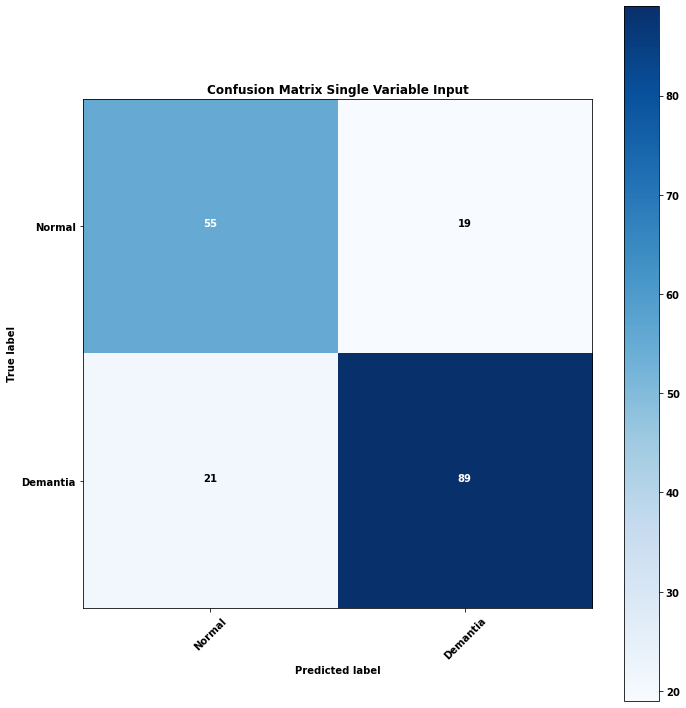

In [38]:
cm_plot_labels = ['Normal', 'Demantia']

# Create a Confusion matrix based on the classes given
plot_confusion_matrix(
    cm=cm,  # np array of the confusion matrix
    classes=cm_plot_labels,  # labels for the confusion matrix
    title='Confusion Matrix Single Variable Input'  # Title of graph
)

Q: **(10 points)** What does this confusion matrix tell you? Try different activation and different hyperparameters to improve the results. Write about what you've learned in 300 or more words.

Answer is in the PDF

### 6.2. Multiple Variables (Features)

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

Q: **(5 points)** Please use Proj1A multiple variables section and the logistics regression using 1 variable to make this Multiple variable logistic regression or classification work!

Answer is in the code below and in the PDF

In [39]:
from tensorflow.keras import layers

In [40]:
dataset_2 = data.copy()
dataset_2.tail()

,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
1732,941_S_4377,69.3,Female,12,Not Hisp/Latino,White,Widowed,1.0,MCI,19850.0,6276.500000,854605.0,3098.750000,14773.000000,16232.75,1.307478e+06
1733,941_S_4420,81.4,Male,18,Not Hisp/Latino,White,Married,0.0,MCI,45450.5,7542.250000,1125837.5,4501.750000,16491.250000,17802.75,1.658722e+06
1734,941_S_4764,82.7,Female,20,Not Hisp/Latino,White,Never married,0.0,MCI,63228.5,6092.500000,915772.5,3933.666667,17667.333333,17832.00,1.483815e+06
1735,941_S_5124,76.7,Female,20,Not Hisp/Latino,White,Married,0.0,NL,NaN,4691.666667,NaN,NaN,NaN,NaN,1.489683e+06
1736,941_S_5193,72.5,Female,16,Not Hisp/Latino,White,Married,0.0,NL,22958.5,7009.500000,1026105.0,4007.500000,15812.500000,17461.00,1.465065e+06


In [41]:
# Rename NL to Normal
dataset_2 = dataset_2.replace(
    {
        "DX": {
            "NL": "Normal",
            "MCI to NL": "MCI to Normal"
        }
    }
)

display(dataset_2['DX'].value_counts())

MCI                586
Dementia           577
Normal             423
MCI to Dementia    108
NL to MCI           29
NL to Dementia       3
MCI to Normal        3
Dementia to MCI      1
Name: DX, dtype: int64

In [42]:
"""
***** Allowed DX Values ******

Notes:
    Change what is allowed output for DX in here

"""
list_dx_values_allowed = [
    "Normal",
    "MCI",
    "Dementia"
]

In [43]:
"""
Get rows where Column DX vlaue != to "NL" or Column DX vlaue != "Demntia".
This means you will get all rows like "MCI to Demntia" and "MCI"
"""
# pd_indices_index_to_drop_2 = dataset_2[
#     (dataset_2['DX'] != "MCI") & 
#     (dataset_2['DX'] != "Normal") &
#     (dataset_2['DX'] != "Dementia")
# ]

# display(pd_indices_index_to_drop_2.head(20))

#####
# This does not work because you need multiple conditions to be true
# pd_indices_index_to_drop_2 = []
# for i in list_dx_values_allowed:
#     pd_indices_index_to_drop_2.extend(list(dataset_2[(dataset_2['DX'] != i)].index.values))
#####

"""

Reference:
    How to dynamically add conditions to .loc pandas
        Notes:
            Dynamic Conditions
            
        Reference:
            https://stackoverflow.com/questions/57468477/how-to-dynamically-add-conditions-to-loc-pandas
"""
pd_indices_index_to_drop_2 = dataset_2[np.logical_and.reduce([(dataset_2['DX'] != i) for i in list_dx_values_allowed])]

# display(pd_indices_index_to_drop_2.head(20))

pd_indices_index_to_drop_2_index = pd_indices_index_to_drop_2.index



In [44]:
# drop these given row indices from data
dataset_2 = dataset_2.drop(pd_indices_index_to_drop_2_index)

In [45]:
# Dataset now has data for DX == "Demntia" and DX == "NL"
dataset_2['DX'].value_counts()

MCI         586
Dementia    577
Normal      423
Name: DX, dtype: int64

In [46]:
# This is to show all NA values in the Dataset
dataset_2.isna().sum()

PTID            0
AGE             0
PTGENDER        0
PTEDUCAT        0
PTETHCAT        0
PTRACCAT        0
PTMARRY         0
APOE4           6
DX              0
Ventricles     20
Hippocampus    50
WholeBrain     12
Entorhinal     92
Fusiform       92
MidTemp        92
ICV             1
dtype: int64

In [47]:
# Drop the NA rows from the dataset
dataset_2 = dataset_2.dropna()

In [48]:
"""
Map 
    "Normal": 0,
    "MCI": 2,
    "Dementia": 1
"""

dict_mapping = {
    key: i for i, key in enumerate(list_dx_values_allowed)
}

cleanup_DX = {"DX": dict_mapping}

dataset_2 = dataset_2.replace(cleanup_DX)

In [49]:
"""
Split the data into to training and testing datasets

"""
train_dataset_2 = dataset_2.sample(frac=0.8,
                                   random_state=0)

test_dataset_2 = dataset_2.drop(train_dataset_2.index)

In [50]:
display(train_dataset)

,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
506,023_S_4035,72.6,Female,16,Not Hisp/Latino,White,Married,1.0,1,66872.750000,7484.166667,9.736240e+05,3232.000,16815.000000,20051.00,1.458280e+06
1319,116_S_4625,63.8,Male,16,Not Hisp/Latino,More than one,Married,2.0,1,33300.750000,7984.200000,1.058310e+06,3350.000,18232.000000,19598.00,1.566908e+06
492,023_S_0916,79.7,Male,16,Not Hisp/Latino,White,Married,2.0,1,49237.000000,6156.000000,9.224115e+05,2612.750,14758.500000,18130.25,1.535440e+06
787,037_S_0627,58.4,Female,12,Not Hisp/Latino,White,Married,2.0,1,32216.333333,6220.000000,8.848287e+05,2806.500,13942.500000,15699.50,1.416243e+06
424,021_S_4402,72.9,Female,12,Not Hisp/Latino,White,Widowed,1.0,1,37532.250000,5560.000000,9.872450e+05,2984.000,14880.250000,18076.00,1.486992e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,036_S_4389,81.1,Male,18,Not Hisp/Latino,White,Married,0.0,0,31026.000000,8746.750000,1.208455e+06,4530.000,22232.500000,23009.75,1.876165e+06
182,010_S_0786,74.5,Male,19,Not Hisp/Latino,White,Married,0.0,1,39816.250000,5307.750000,9.433558e+05,2952.250,15365.750000,18398.00,1.570732e+06
785,037_S_0566,78.8,Male,20,Not Hisp/Latino,White,Married,1.0,1,41156.875000,3833.500000,8.786276e+05,1927.875,14113.875000,16383.50,1.431671e+06
46,003_S_1059,84.5,Female,18,Not Hisp/Latino,White,Married,0.0,1,71384.333333,4801.500000,8.093530e+05,1827.500,14342.500000,17043.00,1.525800e+06


In [51]:
"""
What you want to use as input


"""
train_features_2 = train_dataset_2[
    [
        "AGE",
        "Ventricles",
        "Hippocampus",
        "WholeBrain",
        "Entorhinal",
        "Fusiform",
        "MidTemp",
        "ICV",
    ]
]

test_features_2 = test_dataset_2[
    [
        "AGE",
        "Ventricles",
        "Hippocampus",
        "WholeBrain",
        "Entorhinal",
        "Fusiform",
        "MidTemp",
        "ICV",
    ]
]

##########

"""
What column you want to predict

Notes:
    You are going to match the value of a DX based on the features above

"""

train_labels_2 = train_dataset_2[
    [
        "DX"
    ]
]

test_labels_2 = test_dataset_2[
    [
        "DX"
    ]
]

In [52]:
display(test_features_2)

,AGE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
11,70.7,23015.750000,6849.500000,9.958618e+05,3260.500000,15920.500000,17258.50,1.520520e+06
25,80.9,95389.000000,6249.200000,9.717206e+05,3967.000000,16537.500000,19061.50,1.514396e+06
26,71.9,22596.000000,7775.666667,1.067893e+06,3083.000000,18148.000000,20851.00,1.519063e+06
27,72.8,65000.600000,7055.600000,9.562108e+05,3744.750000,15673.500000,20856.25,1.555516e+06
32,70.0,29475.166667,6613.000000,1.092527e+06,3193.833333,15944.166667,19271.00,1.598262e+06
...,...,...,...,...,...,...,...,...
1696,74.9,49078.500000,7675.000000,1.188090e+06,4023.500000,21800.500000,24033.50,1.736485e+06
1706,72.2,21190.000000,7238.500000,8.884640e+05,3735.333333,12797.833333,18023.50,1.297628e+06
1709,83.0,47491.000000,6025.000000,1.007890e+06,3637.500000,15784.000000,20219.00,1.519123e+06
1718,77.5,59186.857143,5628.166667,1.017463e+06,2221.400000,17610.600000,20142.40,1.671336e+06


In [53]:
def build_and_compile_model(norm, _number_of_possible_prediction_resutls):

    model = keras.Sequential([
        norm,
        layers.Dense(128, activation='elu'),
        layers.Dense(128, activation='elu'),
        layers.Dense(128, activation='elu'),
        layers.Dense(128, activation='elu'),
        Dense(
            _number_of_possible_prediction_resutls,  # Output
            activation='elu',
        ),
        layers.Softmax(),

    ])

    model._name = "joseph_custom_model"

    model.compile(tf.optimizers.Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [54]:
# import autokeras as ak

# def build_and_compile_model_autokeras(x_train, y_train):
    
#     structured_data_classifier = ak.Struc
    
    

In [55]:
# Notes

print("\n", "#"*50, "\n", sep="")

print("train_features_2.columns")
display(train_features_2.columns)

print("\n", "#"*25, "\n", sep="")

print("len(train_features_2.columns)")
display(len(train_features_2.columns))

print("\n", "#"*50, "\n", sep="")

print("train_labels_2.value_counts()")
display(train_labels_2.value_counts())

print("\n", "#"*25, "\n", sep="")

print("len(train_labels_2.value_counts())")
display(len(train_labels_2.value_counts()))

# Drop the NA rows from the dataset
dataset = dataset.dropna()


##################################################

train_features_2.columns


Index(['AGE', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
       'Fusiform', 'MidTemp', 'ICV'],
      dtype='object')


#########################

len(train_features_2.columns)


8


##################################################

train_labels_2.value_counts()


DX
1     435
2     428
0     320
dtype: int64


#########################

len(train_labels_2.value_counts())


3

In [56]:
"""
Assuming that you didn't change anything for output, DX should have NL and Dementia only 
"""
number_of_possible_prediction_resutls = len(train_labels_2.value_counts())

number_of_features_to_input_into_a_layer = len(train_features_2.columns)

train_labels_in_classes_2 = np_utils.to_categorical(
    train_labels_2, 
    number_of_possible_prediction_resutls
)

"""
Assuming you didn't change anything, train_labels_in_classes_2 is a one-hot and should have 2 columns where
    Column 1: NL
    Column 2: Dementia
"""
display(train_labels_in_classes_2)

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [57]:
# Normalizer stuff

# Make the normalzier
normalizer_features = preprocessing.Normalization(axis=-1)

# np array of test features
np_array_test_features = np.array(test_features_2)

# Normalize the data
normalizer_features.adapt(np_array_test_features)

# New model
model_dnn_multivariable = build_and_compile_model(normalizer_features, 
                                                  number_of_possible_prediction_resutls)

display(model_dnn_multivariable.summary())

Model: "joseph_custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 8)                 17        
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
_________________________________________________________________
softmax_1 (Softmax)          (None, 3)         

None

In [58]:
# What np_array_test_features is
display(pd.DataFrame(np_array_test_features).tail())

,0,1,2,3,4,5,6,7
291,74.9,49078.500000,7675.000000,1.188090e+06,4023.500000,21800.500000,24033.50,1.736485e+06
292,72.2,21190.000000,7238.500000,8.884640e+05,3735.333333,12797.833333,18023.50,1.297628e+06
293,83.0,47491.000000,6025.000000,1.007890e+06,3637.500000,15784.000000,20219.00,1.519123e+06
294,77.5,59186.857143,5628.166667,1.017463e+06,2221.400000,17610.600000,20142.40,1.671336e+06
295,80.3,55885.200000,7350.800000,1.105758e+06,4097.500000,19869.000000,20101.25,1.656876e+06


In [59]:
# Prediction
model_dnn_multivariable.predict(np_array_test_features[:10])

array([[0.339, 0.29 , 0.371],
       [0.312, 0.325, 0.363],
       [0.389, 0.316, 0.295],
       [0.298, 0.343, 0.358],
       [0.343, 0.295, 0.362],
       [0.241, 0.464, 0.295],
       [0.317, 0.363, 0.32 ],
       [0.397, 0.184, 0.419],
       [0.29 , 0.289, 0.42 ],
       [0.406, 0.249, 0.344]], dtype=float32)

In [60]:
display(train_features_2)
display(train_features_2.describe().T)

,AGE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
669,71.4,14853.250000,5796.200000,9.209658e+05,2164.25,17876.250000,17853.750000,1.269280e+06
1241,75.5,50622.166667,8380.833333,1.078902e+06,4630.50,15249.833333,21958.833333,1.738638e+06
769,71.5,39378.000000,5283.750000,8.176088e+05,2610.25,13090.500000,12418.250000,1.284760e+06
788,70.6,22536.400000,5717.600000,9.694835e+05,2730.60,17144.300000,18378.100000,1.488574e+06
670,66.1,17713.000000,7115.500000,9.065760e+05,3122.00,13940.500000,16978.000000,1.291000e+06
...,...,...,...,...,...,...,...,...
1122,91.4,94075.750000,7036.500000,9.811595e+05,3566.00,17938.000000,21805.000000,1.566970e+06
1356,73.5,97873.800000,8349.400000,1.243540e+06,3955.80,20349.400000,25148.000000,1.963588e+06
1236,78.5,33003.800000,4624.800000,9.588046e+05,2580.60,16550.200000,18266.600000,1.449420e+06
1403,90.3,53384.800000,6361.200000,9.059626e+05,3045.20,15357.800000,17874.800000,1.365304e+06


,count,mean,std,min,25%,50%,75%,max
AGE,1183.0,7.354328e+01,7.186444,54.400000,6.910000e+01,7.360000e+01,7.850000e+01,9.140000e+01
Ventricles,1183.0,4.228182e+04,23852.178487,6069.500000,2.461721e+04,3.727520e+04,5.366138e+04,1.514055e+05
Hippocampus,1183.0,6.631566e+03,1237.390482,2894.500000,5.735750e+03,6.717167e+03,7.537117e+03,1.094188e+04
WholeBrain,1183.0,1.013104e+06,111468.502835,712985.400000,9.358254e+05,1.008554e+06,1.089934e+06,1.425556e+06
Entorhinal,1183.0,3.398071e+03,785.824008,1143.000000,2.874750e+03,3.443000e+03,3.945167e+03,5.931000e+03
Fusiform,1183.0,1.706231e+04,2772.266839,8863.666667,1.520095e+04,1.708750e+04,1.887675e+04,2.863750e+04
MidTemp,1183.0,1.904685e+04,3155.796565,8850.333333,1.705983e+04,1.905550e+04,2.118038e+04,2.902000e+04
ICV,1183.0,1.527770e+06,166353.445485,870835.471000,1.408898e+06,1.513443e+06,1.634956e+06,2.070530e+06


In [61]:
display(train_labels_2)

,DX
669,1
1241,0
769,2
788,2
670,0
...,...
1122,1
1356,2
1236,2
1403,2


In [62]:
display(train_labels_in_classes_2)
print(len(train_labels_in_classes_2))

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

1183


In [63]:
%%time

# Train model
history_2 = model_dnn_multivariable.fit(
    train_features_2,
    train_labels_in_classes_2,
    epochs=100,
    batch_size=64,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split=0.2,
    use_multiprocessing=True
)

Wall time: 7.61 s


In [64]:
"""
Print how well the model was trained
"""
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.496748,0.816327,0.467241,0.837838,195
196,0.496682,0.816327,0.467275,0.837838,196
197,0.496660,0.818027,0.467336,0.844595,197
198,0.496654,0.818027,0.467387,0.844595,198
199,0.496635,0.818027,0.467407,0.844595,199


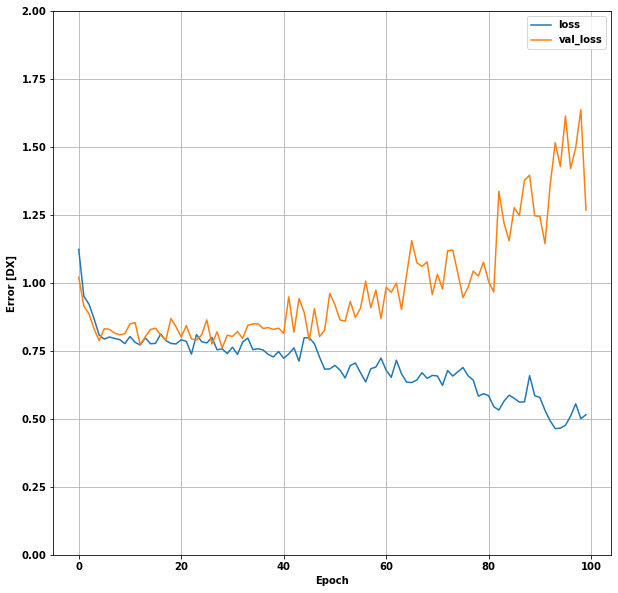

In [65]:
# Print loss graph
plot_loss(history_2)

In [66]:

test_lables_in_classes_2 = np_utils.to_categorical(test_labels_2, 
                                                   number_of_possible_prediction_resutls)

# Test and Record how accurate the model is
test_results['Josephs_custom_model'] = model_dnn_multivariable.evaluate(
    test_features_2,
    test_lables_in_classes_2, 
    verbose=1
)

10/10 [==============================] - 0s 3ms/step - loss: 1.5319 - accuracy: 0.5777


In [67]:
test_pred_2 = model_dnn_multivariable.predict(test_features_2)

preds_classes_2 = np.argmax(test_pred_2, 
                            axis=-1)

print("preds_classes")
display(preds_classes_2)

print("\n", "#"*25, "\n", sep="")

# cm is the confusion matrix in np array form
confusion_matrix_2 = metrics.confusion_matrix(
    test_labels_2, 
    preds_classes_2
)


display(confusion_matrix_2)

preds_classes


array([0, 1, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 2, 0, 2, 2, 1, 0, 0,
       0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 0, 2, 2, 0, 2, 2,
       0, 1, 2, 1, 2, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1,
       1, 2, 2, 2, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 1,
       2, 0, 1, 1, 2, 2, 0, 0, 0, 1, 0, 1, 2, 0, 2, 2, 1, 1, 0, 2, 2, 1,
       1, 2, 2, 2, 2, 0, 0, 1, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 1, 0,
       0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0,
       2, 2, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 0,
       2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 0, 2, 2,
       2, 0, 2, 2, 1, 2, 0, 2, 0, 1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1, 2, 0,
       1, 0, 2, 1, 0, 2, 0, 1, 2, 2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 1, 0,
       0, 0, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1,
       1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 0, 1, 1, 2, 0, 2, 2, 0, 2, 1, 1, 1,
       0, 2, 1, 1, 0, 1, 0, 1, 2, 1], dtype=int64)


#########################



array([[52, 19,  7],
       [50, 54, 20],
       [ 7, 22, 65]], dtype=int64)

dict_keys(['Normal', 'MCI', 'Dementia'])
Confusion matrix, without normalization
[[52 19  7]
 [50 54 20]
 [ 7 22 65]]


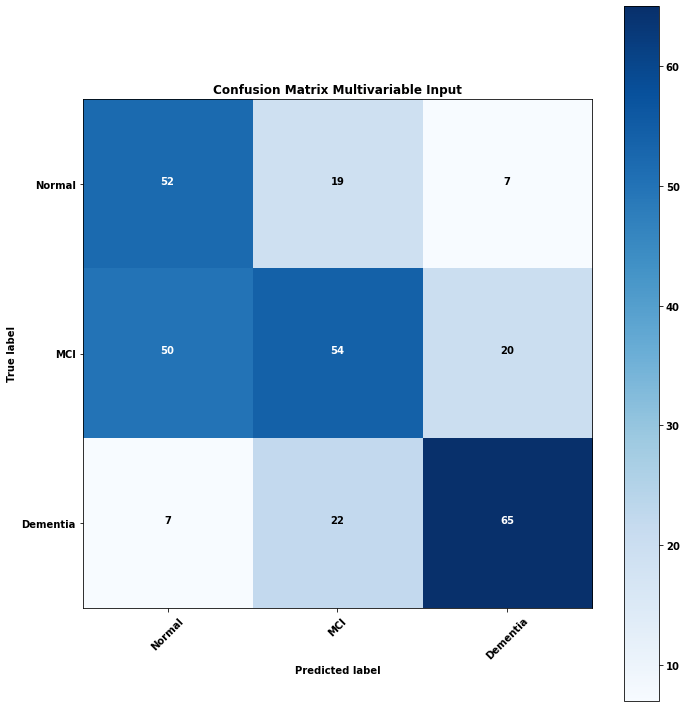

In [68]:
cm_plot_labels_2 = dict_mapping.keys()
print(cm_plot_labels_2)

# Create a Confusion matrix based on the classes given
plot_confusion_matrix(
    cm=confusion_matrix_2,  # np array of the confusion matrix
    classes=cm_plot_labels_2,  # labels for the confusion matrix
    title='Confusion Matrix Multivariable Input'  # Title of graph
)


# Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

* [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
* Similarly, evaluation metrics used for regression differ from classification.
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* Overfitting is a common problem for DNN models, it wasn't a problem for this tutorial. See the [overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.


# Autokeras Model

In [69]:
# Recall the data
display(train_features_2)
display(train_features_2.describe().T)
display(train_labels)
display(train_labels_in_classes_2)


,AGE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
669,71.4,14853.250000,5796.200000,9.209658e+05,2164.25,17876.250000,17853.750000,1.269280e+06
1241,75.5,50622.166667,8380.833333,1.078902e+06,4630.50,15249.833333,21958.833333,1.738638e+06
769,71.5,39378.000000,5283.750000,8.176088e+05,2610.25,13090.500000,12418.250000,1.284760e+06
788,70.6,22536.400000,5717.600000,9.694835e+05,2730.60,17144.300000,18378.100000,1.488574e+06
670,66.1,17713.000000,7115.500000,9.065760e+05,3122.00,13940.500000,16978.000000,1.291000e+06
...,...,...,...,...,...,...,...,...
1122,91.4,94075.750000,7036.500000,9.811595e+05,3566.00,17938.000000,21805.000000,1.566970e+06
1356,73.5,97873.800000,8349.400000,1.243540e+06,3955.80,20349.400000,25148.000000,1.963588e+06
1236,78.5,33003.800000,4624.800000,9.588046e+05,2580.60,16550.200000,18266.600000,1.449420e+06
1403,90.3,53384.800000,6361.200000,9.059626e+05,3045.20,15357.800000,17874.800000,1.365304e+06


,count,mean,std,min,25%,50%,75%,max
AGE,1183.0,7.354328e+01,7.186444,54.400000,6.910000e+01,7.360000e+01,7.850000e+01,9.140000e+01
Ventricles,1183.0,4.228182e+04,23852.178487,6069.500000,2.461721e+04,3.727520e+04,5.366138e+04,1.514055e+05
Hippocampus,1183.0,6.631566e+03,1237.390482,2894.500000,5.735750e+03,6.717167e+03,7.537117e+03,1.094188e+04
WholeBrain,1183.0,1.013104e+06,111468.502835,712985.400000,9.358254e+05,1.008554e+06,1.089934e+06,1.425556e+06
Entorhinal,1183.0,3.398071e+03,785.824008,1143.000000,2.874750e+03,3.443000e+03,3.945167e+03,5.931000e+03
Fusiform,1183.0,1.706231e+04,2772.266839,8863.666667,1.520095e+04,1.708750e+04,1.887675e+04,2.863750e+04
MidTemp,1183.0,1.904685e+04,3155.796565,8850.333333,1.705983e+04,1.905550e+04,2.118038e+04,2.902000e+04
ICV,1183.0,1.527770e+06,166353.445485,870835.471000,1.408898e+06,1.513443e+06,1.634956e+06,2.070530e+06


,DX
506,1
1319,1
492,1
787,1
424,1
...,...
756,0
182,1
785,1
46,1


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [70]:
import autokeras as ak


In [71]:
"""

Reference:
    StructuredDataClassifier
        Reference:
            https://autokeras.com/structured_data_classifier/#fit
"""
clf = ak.StructuredDataClassifier(
    overwrite=True,
    loss="categorical_crossentropy",
    max_trials=1000  # It tries 100 different models by default.
)


In [72]:
%%time

history_clf_autokeras = clf.fit(
    x=train_features_2,
    y=train_labels_in_classes_2,  # Not this one for some reason
#     y=train_labels_2,
    epochs=50,  # Default if 1000
    verbose=1,
    validation_split=0.2,  # Default is 0.2
)

Trial 160 Complete [00h 00m 05s]
val_accuracy: 0.6457399129867554

Best val_accuracy So Far: 0.6860986351966858
Total elapsed time: 00h 21m 02s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
37/37 [==============================] - 1s 4ms/step - loss: 0.9864 - accuracy: 0.4937
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.8699 - accuracy: 0.5689
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.8296 - accuracy: 0.6052
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.8202 - accuracy: 0.5926
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7874 - accuracy: 0.6162
Epoch 6/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7909 - accuracy: 0.6289
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7746 - accuracy: 0.6365
Epoch 8/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7837 - accuracy: 0.6154
Epoch 9/50
37/37 [================

In [73]:
"""
Print how well the model was trained
"""
print(history_clf_autokeras.history.keys())

df_history_autokeras = pd.DataFrame(history_clf_autokeras.history)
df_history_autokeras["val_loss"] = history_clf_autokeras.history.get("loss")  # Apprently you can't get the val loss
df_history_autokeras['epoch'] = history_clf_autokeras.epoch

display(df_history_autokeras.tail())

# display(history_clf_autokeras.history)

history_clf_autokeras.history = df_history_autokeras.to_dict("series")

# display(history_clf_autokeras.history)

dict_keys(['loss', 'accuracy'])


,loss,accuracy,val_loss,epoch
45,0.734488,0.651733,0.734488,45
46,0.726908,0.655959,0.726908,46
47,0.727947,0.669484,0.727947,47
48,0.720395,0.664412,0.720395,48
49,0.706549,0.680473,0.706549,49


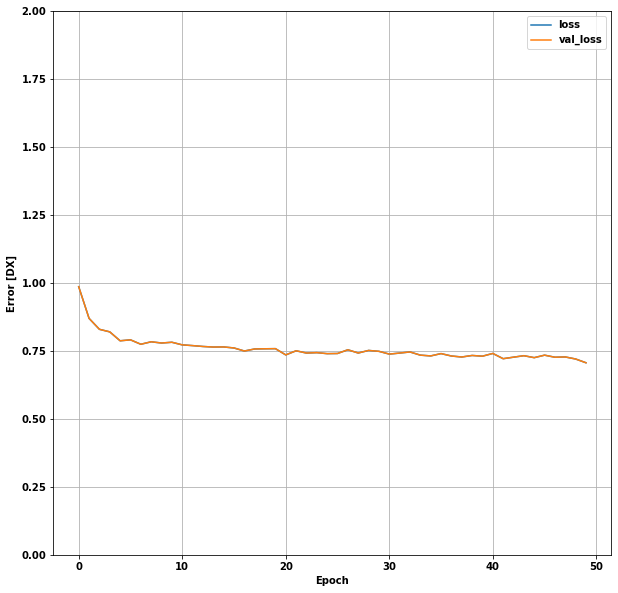

In [74]:
"""
Notes:
    AutoKeras does not return val_loss in its history

"""
# Print loss graph
plot_loss(history_clf_autokeras)

In [75]:
model_autokeras = clf.export_model()

In [76]:
model_autokeras.summary()

# Set Model name
model_autokeras._name = "Josephs_custom_model_autokeras"

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 8)                 0         
_________________________________________________________________
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense (Dense)                (None, 32)                288       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448  

In [77]:
# Save model
try:
    model_autokeras.save("model_autokeras_best", save_format="tf")
except Exception:
    model_autokeras.save("model_autokeras_best.h5")

INFO:tensorflow:Assets written to: model_autokeras_best\assets


In [90]:
test_results['Josephs_custom_model_autokeras'] = model_autokeras.evaluate(
    x=test_features_2,
    y=test_lables_in_classes_2,
    # y=test_labels_2,
)
display(test_results['Josephs_custom_model_autokeras'])

10/10 [==============================] - 0s 3ms/step - loss: 0.7978 - accuracy: 0.5980
['loss', 'accuracy']


[0.7977501749992371, 0.5979729890823364]

In [79]:
test_pred_3 = model_autokeras.predict(test_features_2)

preds_classes_3 = np.argmax(test_pred_3, 
                            axis=-1)

print("preds_classes_3")
display(preds_classes_3)

print("\n", "#"*25, "\n", sep="")

# cm is the confusion matrix in np array form
confusion_matrix_3 = metrics.confusion_matrix(
    test_labels_2, 
    preds_classes_3
)


display(confusion_matrix_3)

preds_classes_3


array([2, 1, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 0,
       0, 2, 2, 2, 1, 1, 1, 0, 1, 0, 0, 2, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2,
       0, 1, 2, 0, 2, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 1,
       2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1, 0, 2, 1,
       2, 0, 1, 1, 2, 2, 1, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0,
       1, 2, 2, 2, 2, 0, 0, 1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0,
       2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 1, 2, 0, 0, 1, 1,
       2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 1, 0, 2, 0, 1, 0, 1, 2, 1,
       1, 0, 1, 1, 0, 2, 0, 1, 2, 2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 1,
       0, 0, 2, 1, 2, 0, 0, 2, 0, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1,
       1, 1, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 2, 1, 2, 0,
       0, 2, 1, 0, 0, 1, 0, 1, 2, 1], dtype=int64)


#########################



array([[44, 28,  6],
       [43, 59, 22],
       [ 4, 16, 74]], dtype=int64)

Confusion matrix, without normalization
[[44 28  6]
 [43 59 22]
 [ 4 16 74]]


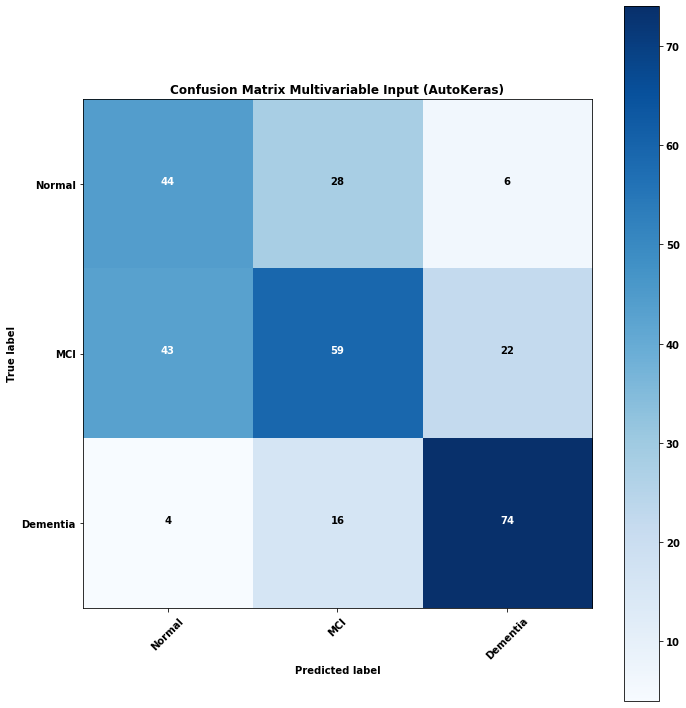

In [80]:
# cm_plot_labels_3 = dict_mapping.keys()
# print(cm_plot_labels_3)

# Create a Confusion matrix based on the classes given
plot_confusion_matrix(
    cm=confusion_matrix_3,  # np array of the confusion matrix
    classes=cm_plot_labels_2,  # labels for the confusion matrix
    title='Confusion Matrix Multivariable Input (AutoKeras)'  # Title of graph
)


In [91]:
pd.DataFrame(test_results, index=['Loss',"Accuracy"]).T

,Loss,Accuracy
hippocampus_model,0.518353,0.782609
Josephs_custom_model,1.531904,0.577703
Josephs_custom_model_autokeras,0.797750,0.597973


# Conclusion

__Looks like the AutoKeras failed, it's probably the features that I have selected suck...__